# Задача 1.4
Частота распределения слов в языке описывается законом Ципфа.

Проверить, что он действительно описывает частоту слов (через формальный критерий) на основе анализа двух документов: Анны Карениной и новостного корпуса. Можно ли утверждать, что параметры закона Ципфа для этих двух корпусов совпадают?

Пояснение по закону Ципфа: закон Ципфа утверждает, что в выборке из N элементов частота (вероятность) встретить элемент с рангом K равняется: const / K^a, где a --- параметр распределения. Подробнее можно посмотреть здесь.

$$f(k,s,N) = \frac{С}{k^s},~~C = const$$

# Решение

## 1) Предобработка
Прежде всего прочитаем оба файла и создадим словари с подсчетом количества слов. Для чистоты эксперимента оставим слова только из русских букв.

In [395]:
import scipy.stats as st
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.optimize import curve_fit
from statsmodels.sandbox.stats.multicomp import multipletests 
%matplotlib inline

In [100]:
chars = "а б в г д е ё ж з и й к л м н о п р с т у ф х ц ч ш щ ъ ы ь э ю я".split(" ")
chars += [char.upper() for char in chars]
chars = set(chars)

In [101]:
def deep_split(string, arr = chars):
    prev = 0
    ans = []
    for i, char in enumerate(string):
        if not char in arr:
            ans.append(string[prev:i])
            prev = i + 1
    ans.append(string[prev:])
    return ans

In [325]:
def count_words(filename):
    all_words = dict()
    with open(filename, "r") as file:
        for line in file.readlines():
            for word in deep_split(line):
                word = word.lower()
                if len(word) > 0:
                    if not word in all_words:
                        all_words[word] = 0
                    all_words[word] += 1
    return sorted([(count, word) for word, count in all_words.items()], key=lambda pair: -pair[0])

In [326]:
tolstoj_dictionary = count_words("data/tolstoj.txt")
news_dictionary = count_words("data/news.txt")

In [327]:
len(tolstoj_dictionary), len(news_dictionary)

(32812, 11843)

In [328]:
tolstoj_dictionary[:10]

[(12916, 'и'),
 (6538, 'не'),
 (6141, 'что'),
 (5723, 'в'),
 (5552, 'он'),
 (3594, 'на'),
 (3436, 'она'),
 (3358, 'с'),
 (3217, 'я'),
 (2686, 'как')]

In [329]:
news_dictionary[:10]

[(1964, 'в'),
 (1013, 'и'),
 (760, 'что'),
 (722, 'на'),
 (401, 'с'),
 (369, 'не'),
 (345, 'как'),
 (321, 'он'),
 (284, 'по'),
 (214, 'из')]

## 2) Подсчет рангов
Теперь нужно для каждого слова получить его ранг.

In [330]:
def get_data(pairs):
    names = []
    counts = []
    for pair in pairs:
        counts.append(pair[0])
        names.append(pair[1])
    counts = np.array(counts)
    return st.rankdata(-counts), counts, names

In [331]:
tolstoj_ranks, tolstoj_counts, tolstoj_names = get_data(tolstoj_dictionary)
news_ranks, news_counts, news_names = get_data(news_dictionary)

## 3) Получим оценку для параметра s методом максимального правдоподобия

Пусть каждое слово в тексте - случайная величина $X$. 

$W_k$ - слово ранга $k$. Текст - выборка $X^N$

$$P(X = W_k) = \frac{k^{-s}}{\sum_{n=1}^N n^{-s}}$$

Провернем метод максимального правдоподобия

$$ \mathcal L(X^N) = \prod_{i=1}^N \frac{k_i^{-s}}{\sum_{n=1}^N n^{-s}}$$

$$\log \mathcal L(X^N) = -s \sum_{i=1}^N \log k_i - N\log \sum_{n=1}^N n^{-s}$$

$$\frac{\partial \log \mathcal L(X^N)}{\partial s} = -\sum_{i=1}^N \log k_i + N\frac{\sum_{n=1}^N \log (n)~n^{-s}}{\sum_{n=1}^N n^{-s}} = 0$$

Из последнего уравнения можно найти $s$

In [344]:
def L(ranks, counts, s):
    N = sum(counts)
    n = np.arange(N) + 1.
    return -sum(np.log(ranks)*counts) + N*sum(np.log(n)*n**(-s))/sum(n**(-s))

In [368]:
tolstoj_s = root_scalar(lambda s: L(tolstoj_ranks, tolstoj_counts, s), bracket = (1, 2)).root

In [360]:
news_s = root_scalar(lambda s: L(news_ranks, news_counts, s), bracket = (0.1, 2)).root

In [361]:
tolstoj_popt, _ = curve_fit(lambda x, a, b:a*x+b, np.log(tolstoj_ranks), 
                            np.log(tolstoj_counts))
news_popt, _ = curve_fit(lambda x, a, b:a*x+b, np.log(news_ranks), 
                         np.log(news_counts))

In [362]:
tolstoj_popt[0], -tolstoj_s

(-1.0389777174200896, -1.055090307491394)

In [363]:
news_popt[0], -news_s

(-0.7984609218785796, -0.9330834761008905)

Здесь нет ничего удивительного, LS не обязан совпадать с MLE. Считается, что MLE лучше.

## 4) Убедимся в адекватности результата
Построим графики в логарифмическом масштабе и сравним реальное и MLE распределения

In [372]:
def get_probabilities(ranks, counts, s):
    C = 1./sum((np.arange(sum(counts))+1.)**(-s))
    return np.array([C*k**(-s) for k in ranks])

In [373]:
def plot_Zipf(ranks, counts, s):
    plt.figure(figsize = (6,6))
    probabilities_real = counts/sum(counts)
    probabilities_predicted = get_probabilities(ranks, counts, s)
    plt.scatter(np.log(ranks), np.log(probabilities_real), s = 2)
    plt.plot(np.log(ranks), np.log(probabilities_predicted), color="red")
    plt.xlabel("$\log~rank(word)$")
    plt.title("Tolstoj")
    plt.ylabel("$\log~count$")
    plt.grid()
    plt.show()

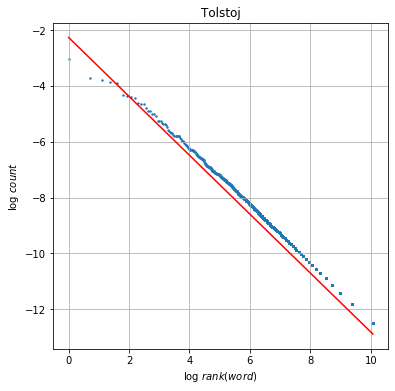

In [374]:
plot_Zipf(tolstoj_ranks, tolstoj_counts, tolstoj_s)

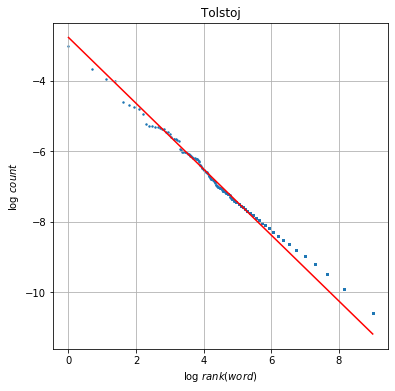

In [375]:
plot_Zipf(news_ranks, news_counts, news_s)

## 5) Проверим гипотезу о распределении

Теперь проверим гипотезу о том, что данные имеют такое распределение, с помощью хи-квадрат (Критерий согласия Пирсона). Необходимо разбить вариационный ряд так, чтобы $np_i > 5$ в 80% ячеек (для хи-квадрат необходимо большое количество данных). Для простоты и надежности обеспечу это условие во всех ячейках, кроме, быть может, последней.

In [433]:
def make_splitting(probabilities, n, thresh = 5.):
    nprob = n*probabilities
    intervals = []
    curr = []
    score = 0.
    for i, p in enumerate(nprob):
        score += p
        curr.append(i)
        if score > thresh:
            score = 0
            intervals.append(curr)
            curr = []
    return intervals

In [434]:
def intervals_summing(array, intervals):
    summs = []
    for interval in intervals:
        summ = 0
        for i in interval:
            summ += array[i]
        summs.append(summ)
    return np.array(summs)

In [435]:
tolstoj_intervals = make_splitting(get_probabilities(tolstoj_ranks, tolstoj_counts, tolstoj_s), 
                                   sum(tolstoj_counts))
news_intervals = make_splitting(get_probabilities(news_ranks, news_counts, news_s), sum(news_counts))

In [436]:
tolstoj_predicted = intervals_summing(get_probabilities(tolstoj_ranks, tolstoj_counts, tolstoj_s), 
                  tolstoj_intervals)
news_predicted = intervals_summing(get_probabilities(news_ranks, news_counts, news_s), news_intervals)

In [437]:
tolstoj_observed = intervals_summing(tolstoj_counts/sum(tolstoj_counts), tolstoj_intervals)
news_observed = intervals_summing(news_counts/sum(news_counts), news_intervals)

Теперь получим p-value с помощью хи-квадрат, учитывая, что 1 параметр мы уже оценили по данным. 
После этого сделаем поправку на множественное тестирование (Холм).

In [438]:
tolstoj_p = st.chisquare(tolstoj_observed, tolstoj_predicted, ddof=1)[1]
news_p = st.chisquare(news_observed, news_predicted, ddof=1)[1]

In [439]:
_, p_vals, __, ___ = multipletests([tolstoj_p, news_p], method="holm")
tolstoj_p_corrected, news_p_corrected = p_vals
tolstoj_p_corrected, news_p_corrected

(1.0, 1.0)

Таким образом, критерий не опровергает гипотезу о том, что распределение слов в каждом из документов описывается законом Ципфа.

## 7) Сравним параметры распределения Ципфа для документов

In [440]:
tolstoj_s, news_s

(1.055090307491394, 0.9330834761008905)

Они близки. Повторим предыдущий пункт, поменяв местами параметры и увеличив число степеней свободы в хи-квадрат на 1 (поскольку теперь используем параметры, не оценивавшиеся по выборке)

In [453]:
tolstoj_intervals = make_splitting(get_probabilities(tolstoj_ranks, tolstoj_counts, news_s), 
                                   sum(tolstoj_counts))
news_intervals = make_splitting(get_probabilities(news_ranks, news_counts, tolstoj_s), sum(news_counts))

In [454]:
tolstoj_predicted = intervals_summing(get_probabilities(tolstoj_ranks, tolstoj_counts, news_s), 
                  tolstoj_intervals)
news_predicted = intervals_summing(get_probabilities(news_ranks, news_counts, tolstoj_s), news_intervals)

In [455]:
tolstoj_observed = intervals_summing(tolstoj_counts/sum(tolstoj_counts), tolstoj_intervals)
news_observed = intervals_summing(news_counts/sum(news_counts), news_intervals)

In [458]:
tolstoj_p = st.chisquare(tolstoj_observed, tolstoj_predicted)[1]
news_p = st.chisquare(news_observed, news_predicted)[1]
tolstoj_p, news_p

(1.0, 1.0)

# Вывод
Таким образом, распределения слов в обоих документах подчиняются закону Ципфа. Поскольку найдены два значения параметра, такие что при каждом из них распределение частот не противоречит закону Ципфа, то опровергуть гипотезу о том, что истинные значения этого параметра могут иметь одинаквое значение, нельзя. Скорее всего, они на самом деле равны, ибо оба документа написаны на русском языке.